In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
#download nltk's 'stopwords' for removal in pre-process
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cvveljanovski\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [74]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split,cross_validate

In [64]:
data = pd.read_csv(r"C:\\Users\\cvveljanovski\\Desktop\\Exercising Naive Bayes\\uci-news-aggregator.csv")

In [65]:
#data.head()

In [66]:
df = data.copy()

In [67]:
df.drop(['URL','STORY',"TIMESTAMP","HOSTNAME","ID","PUBLISHER"],inplace=True,axis=1)

In [109]:
X = df["TITLE"]
Y = df["CATEGORY"]

In [127]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)

In [128]:
df = pd.concat([X_train, Y_train], axis = 1)

In [129]:
df_test = pd.concat([X_test, Y_test], axis = 1)

In [130]:
#Lets see which message which titles are the most frequent for each category
df.groupby("CATEGORY").describe()

TITLE                                                             \
           count  unique                                                top   
CATEGORY                                                                      
b          80905   78758                Posted by Shoaib-ur-Rehman Siddiqui   
e         106801  103940  The article requested cannot be found! Please ...   
m          31852   30879                                     Share this on:   
t          76135   74260                                      Business Wire   

               
         freq  
CATEGORY       
b          37  
e          82  
m           6  
t          20

C:\Users\cvveljanovski\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\cvveljanovski\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


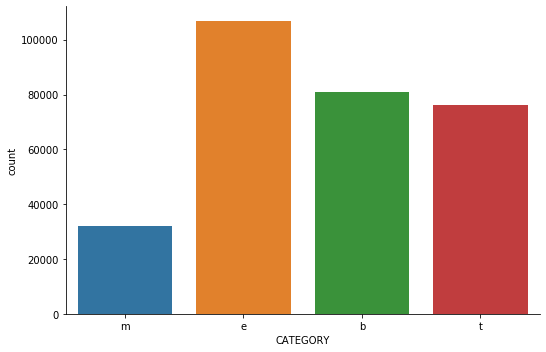

In [131]:
sns.factorplot(x="CATEGORY", data = df, kind = "count", size = 5, aspect = 1.5)

In [132]:
#next step is to pre-process text data 
#firstly import useful functions
import string
from nltk.corpus import stopwords

In [133]:
#    define a function to:
#    1. Remove punctuations
#    2. tokenize the terms in each text message
#    3. Remove stopwords

def text_process(content):
    removepunc=[word for word in content if word not in string.punctuation]
    removepunc=''.join(removepunc)
    
    return[term for term in removepunc.split() if term.lower() not in stopwords.words('english')]

In [134]:
df['TITLE'].head(5).apply(text_process) #check if defined function works 

46521     [Air, pollution, kills, 7, million, people, ev...
328284    [Kim, Kardashian, Shares, Adorable, TBT, Ever,...
333711    [Dow, Jones, Industrial, Average, climbed, 17,...
120549            [Yahoos, buying, spree, appears, slowing]
100179    [LabGrown, Vaginas, Implanted, Successfully, F...
Name: TITLE, dtype: object

In [135]:
#Next step is to vectorize each term and weight it by tf-idf model
#firstly import cpuntvectorizer to measure the frequency of each word term

from sklearn.feature_extraction.text import CountVectorizer 
bow_process=CountVectorizer(analyzer=text_process).fit(df['TITLE'])

print (len(bow_process.vocabulary_)) #check the number of terms (vectors)

89909


In [136]:
#transform vectors to term-document incidence matrix
df_bow= bow_process.transform(df['TITLE'])

In [137]:
print('Shape :', df_bow.shape) #check the size of term-document incidence matrix

Shape : (295693, 89909)


In [138]:
#weight vectors by tf-idf model
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_trans=TfidfTransformer().fit(df_bow)
df_tfidf= tfidf_trans.transform(df_bow)

print(df_tfidf.shape) #check the size of weighted term-document incidence matrix

(295693, 89909)


In [139]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_model=MultinomialNB().fit(df_tfidf, df['CATEGORY']) #train Naive Bayes classifier

In [140]:
df_test.head()

,TITLE,CATEGORY
153245,iPhone 6 Release Date Pushed Back Due to Issue...,t
308611,Samsung Galaxy S4 vs Galaxy S3: Budget-Friendl...,t
354964,Warner Brothers Reveals Superman's 'New Look',e
151664,Local restaurants raising funds for HIV/AIDS T...,m
393995,Amazon Fire breaks ground for phones,t


In [141]:
df_test['TITLE'].head(5).apply(text_process)

153245    [iPhone, 6, Release, Date, Pushed, Back, Due, ...
308611    [Samsung, Galaxy, S4, vs, Galaxy, S3, BudgetFr...
354964    [Warner, Brothers, Reveals, Supermans, New, Look]
151664    [Local, restaurants, raising, funds, HIVAIDS, ...
393995               [Amazon, Fire, breaks, ground, phones]
Name: TITLE, dtype: object

In [142]:
#transform vectors to term-document incidence matrix for the test set
df_test_bow= bow_process.transform(df['TITLE'])
df_test_tfidf=tfidf_trans.transform(df_test_bow) 
#now we have vectorized test data that can be classified by three models

print('Shape :', df_test_bow.shape)

Shape : (295693, 89909)


In [155]:
from sklearn.metrics import classification_report
NB_predict = naive_bayes_model.predict(df_test_tfidf)    # test the Naive Bayes model and get prediction

In [153]:
df_test_bow

<295693x89909 sparse matrix of type '<class 'numpy.int64'>'
	with 2079876 stored elements in Compressed Sparse Row format>

In [159]:
print(classification_report(df_test['CATEGORY'],NB_predict))    # generate evaluation report of NB model

ValueError: Found input variables with inconsistent numbers of samples: [126726, 295693]

In [160]:
#create pipelines for the model to systematically pre-process text data based on our previous pre-processing steps
#to store pipelines of workfolow
#for further study use

from sklearn.pipeline import Pipeline
NB_classifier = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),   #vectorize terms within text data sets
    ('tfidf', TfidfTransformer()),  #weight terms
    ('classifier', MultinomialNB()),   #implement Naive Bayes classifier
])

In [161]:
NB_classifier.fit(df['TITLE'],df['CATEGORY'])  #train the model by fitting training data sets


Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001F7F14EFA60>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [162]:
NB_prediction=NB_classifier.predict(df_test['TITLE'])  #test the model and get prediction
print(classification_report(df_test['CATEGORY'],NB_prediction))  #create evaluation report

              precision    recall  f1-score   support

           b       0.89      0.91      0.90     35062
           e       0.94      0.97      0.96     45668
           m       0.98      0.81      0.89     13787
           t       0.90      0.90      0.90     32209

   micro avg       0.92      0.92      0.92    126726
   macro avg       0.93      0.90      0.91    126726
weighted avg       0.92      0.92      0.92    126726

